<a href="https://colab.research.google.com/github/linhnguyen222/DPS-Silo/blob/master/propaganda_Linh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
from tqdm.auto import tqdm

In [ ]:
from __future__ import print_function
import torch

In [ ]:
from google.colab import drive
# drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)
directory = '/content/drive/My Drive/DSP/data/protechn_corpus_eval/train'
testDirectory = '/content/drive/My Drive/DSP/data/protechn_corpus_eval/test'
devDirectory = '/content/drive/My Drive/DSP/data/protechn_corpus_eval/dev'

Mounted at /content/drive


In [ ]:
import glob
import os

In [ ]:
import re
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.stem.porter import PorterStemmer
import string

def preprocess_text(text, remove_stop = True, stem_words = False, remove_mentions_hashtags = True):
  """
  eg:
  input: preprocess_text("@water #dream hi hello where are you going be there tomorrow happening happen happens",  
  stem_words = True) 
  output: ['tomorrow', 'happen', 'go', 'hello']
  """
  

  if remove_mentions_hashtags:
      text = re.sub(r"@(\w+)", " ", text)
      text = re.sub(r"#(\w+)", " ", text)
      
  text = re.sub(r"[^\x00-\x7F]+", " ", text)
  regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
  nopunct = regex.sub(" ", text.lower())
  words = (''.join(nopunct)).split()
  
  if(remove_stop):
      words = [w for w in words if w not in STOP_WORDS]
      words = [w for w in words if len(w) > 2]  # remove a,an,of etc.
      
  if(stem_words):
      stemmer = PorterStemmer()
      words = [stemmer.stem(w) for w in words]
      
  return list(words) 

In [ ]:
import spacy
from spacy import displacy
from spacy.matcher import PhraseMatcher
nlp = spacy.load("en_core_web_sm")
matched_sents = []
def collect_sents(matcher, doc, i, matches):
    match_id, start, end = matches[i]
    span = doc[start:end]  # Matched span
    sent = span.sent  # Sentence containing matched span
    # Append mock entity for match in displaCy style to matched_sents
    # get the match span by ofsetting the start and end of the span with the
    # start and end of the sentence in the doc
    match_ents = [{
        "start": span.start_char - sent.start_char,
        "end": span.end_char - sent.start_char,
        "label": "MATCH",
    }]
    matched_sents.append({"text": sent.text, "ents": match_ents, "id": i })
    # matched_sents = sent.text
    # print(matched_sents)


# for doc, label, start, end in labels.values:
def getMatchSentence(textNlp, matchedString, doc, start, end):
  matcher = PhraseMatcher(nlp.vocab)
  id = "{doc}-{start}-end".format(doc=doc, start=start, end=end)
  matcher.add(id, collect_sents, nlp(matchedString)) 
  matches = matcher(textNlp)
  matchSentence = matched_sents[0]["text"] if len(matched_sents) != 0  else ""

  # reformat so that we have the text in its original form
  matchSentence = matchSentence.replace("`", "'").replace("'", "\"")
  matched_sents.pop(0) if len(matched_sents) != 0  else matched_sents
 # now we clean the sentence
  matchSentence = " ".join(preprocess_text(matchSentence))
  return matchSentence


In [ ]:
# Get all text file from train
os.chdir(directory)
myFiles = glob.glob('*.txt')
trainData = pd.DataFrame(columns=["doc", "label", "phrase", "sentence"])
for textFileName in tqdm(myFiles):
  # Read text and label name
  try: 
    lblFileName = textFileName.replace(".txt", ".labels.tsv")
    labels = pd.read_csv(lblFileName, header=None, delim_whitespace=True)
    labels.columns = ['doc', 'label', 'start', 'end']
    text = open(textFileName).read()

    # format text because spaCy doesnt work if the match phrase is in quotation mark
    text = text.replace("'", "`").replace("\"", "'")
    textNlp= nlp(text)
    df = pd.concat([pd.DataFrame([[doc, label, text[start:end].replace("\"", "").strip(), getMatchSentence(textNlp, text[start:end].replace("\"", "").strip(), doc, start, end)]], columns=["doc", "label", "phrase", "sentence"]) for doc, label, start, end in labels.values],
            ignore_index=True)
    trainData = pd.concat([trainData, df], axis=0,ignore_index=True)
  except:
    continue
trainData.head()

,doc,label,phrase,sentence
0,7618745059,Whataboutism,but they didn’t prosecute Hillary Clinton,interpreted law case criminal saucier told fox...
1,7618745059,Whataboutism,did the same thing and weren’t treated as crim...,guys ship thing weren treated criminals
2,7618745059,Causal_Oversimplification,“They used me as an example because of [the ba...,example backlash hillary clinton continued all...
3,7618745059,"Exaggeration,Minimisation",actively destroyed his life an made it all but...,government actively destroyed life impossible ...
4,729348908,Appeal_to_fear-prejudice,a holy war between Muslims and non-Muslims,course conversations patel discussed desire ho...


In [ ]:
os.chdir(testDirectory)
myTestFiles = glob.glob('*.txt')
testData = pd.DataFrame(columns=["doc", "label", "phrase", "sentence"])
for textFileName in tqdm(myTestFiles):
  # Read text and label name
  try: 
    lblFileName = textFileName.replace(".txt", ".labels.tsv")
    labels = pd.read_csv(lblFileName, header=None, delim_whitespace=True)
    labels.columns = ['doc', 'label', 'start', 'end']
    text = open(textFileName).read()

    # format text because spaCy doesnt work if the match phrase is in quotation mark
    text = text.replace("'", "`").replace("\"", "'")
    textNlp= nlp(text)
    df = pd.concat([pd.DataFrame([[doc, label, text[start:end].replace("\"", "").strip(), getMatchSentence(textNlp, text[start:end].replace("\"", "").strip(), doc, start, end)]], columns=["doc", "label", "phrase", "sentence"]) for doc, label, start, end in labels.values],
            ignore_index=True)
    testData = pd.concat([testData, df], axis=0,ignore_index=True)
  except:
    continue
testData.head()

,doc,label,phrase,sentence
0,999001299,Flag-Waving,American people,warned prior dealings ssmu jewish identity sec...
1,999001299,Repetition,lie,lew board members passionately advocated favor...
2,999001299,Repetition,lied,malevolent bds campaign mcgill belatedly come ...
3,999001299,Loaded_Language,frivolous,enlightened progressive school suddenly transf...
4,999001299,Loaded_Language,rampant,instant case mcgill bds campaigners dispensed ...


In [ ]:
testData["sentence"][0]

'warned prior dealings ssmu jewish identity secret lest sabotage chances'

In [ ]:
os.chdir(devDirectory)
myDevFiles = glob.glob('*.txt')
devData = pd.DataFrame(columns=["doc", "label", "phrase", "sentence"])
for textFileName in tqdm(myDevFiles):
  # Read text and label name
  try: 
    lblFileName = textFileName.replace(".txt", ".labels.tsv")
    labels = pd.read_csv(lblFileName, header=None, delim_whitespace=True)
    labels.columns = ['doc', 'label', 'start', 'end']
    text = open(textFileName).read()

    # format text because spaCy doesnt work if the match phrase is in quotation mark
    text = text.replace("'", "`").replace("\"", "'")
    textNlp= nlp(text)
    df = pd.concat([pd.DataFrame([[doc, label, text[start:end].replace("\"", "").strip(), getMatchSentence(textNlp, text[start:end].replace("\"", "").strip(), doc, start, end)]], columns=["doc", "label", "phrase", "sentence"]) for doc, label, start, end in labels.values],
            ignore_index=True)
    devData = pd.concat([testData, df], axis=0,ignore_index=True)
  except:
    continue
devData.head()

,doc,label,phrase,sentence
0,999001299,Flag-Waving,American people,warned prior dealings ssmu jewish identity sec...
1,999001299,Repetition,lie,lew board members passionately advocated favor...
2,999001299,Repetition,lied,malevolent bds campaign mcgill belatedly come ...
3,999001299,Loaded_Language,frivolous,enlightened progressive school suddenly transf...
4,999001299,Loaded_Language,rampant,instant case mcgill bds campaigners dispensed ...


In [ ]:
trainData.describe()

,doc,label,phrase,sentence
count,5114,5114,5114,5114
unique,281,18,4403,2674
top,783702663,Loaded_Language,autonomy,autonomy life constant prerequisite maintainin...
freq,231,1811,21,44


In [ ]:
# labelInfo = trainData[["label"].value_counts()]
labelInfo = trainData[["label", "sentence"]].groupby(by=["label"]).count().reset_index()

In [ ]:
labelInfo

,label,sentence
0,Appeal_to_Authority,91
1,Appeal_to_fear-prejudice,187
2,Bandwagon,10
3,Black-and-White_Fallacy,97
4,Causal_Oversimplification,170
5,Doubt,423
6,"Exaggeration,Minimisation",398
7,Flag-Waving,206
8,Loaded_Language,1811
9,"Name_Calling,Labeling",931


In [ ]:
import plotly.express as px
fig = px.pie(labelInfo, values="sentence", names="label", title="Distribution of labels")
fig.show()

In [ ]:
# stops = stopwords.words("english")

# def normalize(comment, lowercase, remove_stopwords):
#   if lowercase:
#     comment = comment.lower()
#   comment = nlp(comment)
#   lemmatized = list()
#   for word in comment:
#     lemma = word.lemma_.strip()
#     if lemma:
#       if not remove_stopwords or (remove_stopwords and lemma not in stops):
#         lemmatized.append(lemma)
#   return " ".join(lemmatized)
# Explorative task using spaCy
sentence_text = ' '.join(trainData['sentence'])
doc = nlp(' '.join(preprocess_text(sentence_text)))

x = doc[0]
print('word:', x, '\n')
print('part of speech:', x.pos_, '\n')
print('sentiment:', x.sentiment,'\n')
print('sentiment:', x.sentiment,'\n')
print('word vector:', x.vector)

word: interpreted 

part of speech: VERB 

sentiment: 0.0 

sentiment: 0.0 

word vector: [ 3.0343883  -3.750167   -0.928719    1.6470629   1.7190307  -0.7121873
 -0.4338514   4.654498    2.5160146   1.0844514   2.6064878  -0.45748934
 -0.98389083 -4.4254737   0.20492843  0.316422    0.45347315  3.2947745
  0.01253429  0.78905517  0.7577066  -4.753515   -1.4073963   0.04084176
 -0.96920186  0.40185523 -1.6567066  -1.7462039  -2.4742591  -2.6213813
 -1.9883845  -0.9284941   2.7043738  -0.99468726 -0.55624056 -1.9708086
  3.3207269  -1.1958678   1.464607   -0.37742314  0.41884905  2.3968499
  1.6800246   3.3990312   0.70407003 -0.32009593 -1.7207618  -1.9469607
  1.992593    1.9678866  -1.0841866  -1.4790103   1.1583052  -0.3702048
 -1.0147747  -1.5415416   0.04105753 -0.8867867   1.1723249   0.44166028
 -2.9982855  -4.5992503  -0.40138793  2.969132   -2.283688   -1.8961564
  2.6907568  -1.6650016   0.19120526  4.490702    0.7372501   0.68763477
  0.21692109  1.5782244   0.598561   -1.40

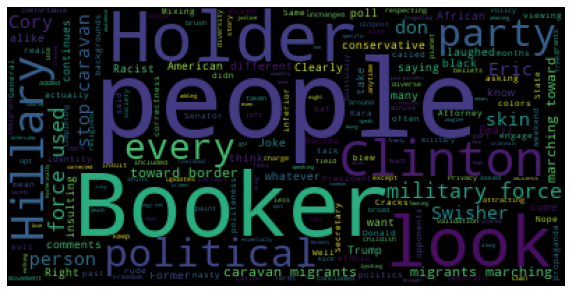

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def make_wc(word_list):
    wordcloud = WordCloud()
    wordcloud = WordCloud().generate(text)
    # wordcloud.fit_words(dict(Counter(word_list).most_common(40)))

    fig=plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
make_wc([token.text for token in doc if token.pos_ in ['NOUN']])
# I already removed stop words but they dont include inflection

After this I am trying to test the LSTM model from Multiclass Text Classification using LSTM in Pytorch https://towardsdatascience.com/multiclass-text-classification-using-lstm-in-pytorch-eac56baed8df

In [ ]:
#@Keras model {display-mode: "form"}

# This code will be hidden when the notebook is loaded.
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

In [ ]:
X_train = trainData[["sentence"]]
X_test = testData[["sentence"]]
X_dev = devData[["sentence"]]
Y_train = trainData[["label"]]
Y_test = testData[["label"]]
Y_dev = devData[["label"]]


In [ ]:
from sklearn.preprocessing import OneHotEncoder


In [ ]:
# Make the label into binary matrix form
def binarizerLabels(labelsFrame):
  mlb = OneHotEncoder()
  label_vec = labelsFrame.label.values
  mlb.fit(label_vec.reshape(-1, 1))
  a = mlb.transform(label_vec.reshape(-1, 1)).todense()
  return pd.DataFrame(a, columns = mlb.categories_)

In [ ]:
Y_train_vec = binarizerLabels(Y_train)
Y_dev_vec = binarizerLabels(Y_dev)
Y_test_vec = binarizerLabels(Y_test)
# binarizerLabels(Y_train)


In [ ]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [ ]:
X_train

,sentence
0,interpreted law case criminal saucier told fox...
1,guys ship thing weren treated criminals
2,example backlash hillary clinton continued all...
3,government actively destroyed life impossible ...
4,course conversations patel discussed desire ho...
...,...
5109,bds standards manifestly anti semitic campaign...
5110,bds standards manifestly anti semitic campaign...
5111,vitriolic bds campaign immediately sparked out...
5112,vitriolic bds campaign immediately sparked out...


In [ ]:
np.mean([len(x.split()) for x in X_train.sentence.values])

12.176574110285491

Create text-embedding
https://stackabuse.com/python-for-nlp-word-embeddings-for-deep-learning-in-keras/

In [ ]:
# convert text to vector
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train.sentence.values)

X_train_tok = tokenizer.texts_to_sequences(X_train.sentence.values)
X_test_tok = tokenizer.texts_to_sequences(X_test.sentence.values)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 14

X_train_tok = pad_sequences(X_train_tok, padding='post', maxlen=maxlen)
X_test_tok = pad_sequences(X_test_tok, padding='post', maxlen=maxlen)

In [ ]:
X_train.values[0]

array(['interpreted law case criminal saucier told fox news referring prosecuting authorities case didn prosecute hillary clinton'],
      dtype=object)

In [ ]:
X_train_tok

array([[  42,  129, 1351, ..., 2844,  148,   24],
       [3415, 3416,  123, ...,    0,    0,    0],
       [ 958, 1667,  148, ...,    0,    0,    0],
       ...,
       [ 860, 2707,  778, ..., 4238,   69,  131],
       [ 860, 2707,  778, ..., 4238,   69,  131],
       [8427,  603, 2461, ...,    0,    0,    0]], dtype=int32)

In [ ]:
# using GloVe word embeddings to convert text inputs to their numeric counterparts
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('/content/drive/My Drive/DSP/data/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector


In [ ]:
Y_train

,label
0,Whataboutism
1,Whataboutism
2,Causal_Oversimplification
3,"Exaggeration,Minimisation"
4,Appeal_to_fear-prejudice
...,...
5109,Appeal_to_fear-prejudice
5110,Doubt
5111,Doubt
5112,Loaded_Language


In [ ]:
import torch
import torch.nn as nn
class Model(nn.Module):
  def __init__(self, vocab_size, out_size):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, 100) # , _weight=torch.tensor(embedding_matrix).to(torch.float))
    self.lstm = nn.LSTM(100, 512, 1, batch_first=True)
    self.dense = nn.Linear(512, 18)
  
  def forward(self, x):
    x = self.embedding(x)
    h0 = torch.randn(1, x.shape[0], 512).to(torch.float)
    c0 = torch.randn(1, x.shape[0], 512).to(torch.float)
    _, (h, c) = self.lstm(x, (h0, c0))

    return self.dense(h.squeeze(0))


model = Model(vocab_size, 18)

In [ ]:
model.dense.weight

Parameter containing:
tensor([[-0.0359,  0.0110,  0.0312,  ..., -0.0379,  0.0358,  0.0221],
        [-0.0419,  0.0440,  0.0321,  ..., -0.0259, -0.0296, -0.0041],
        [-0.0166,  0.0306, -0.0018,  ...,  0.0233, -0.0363, -0.0013],
        ...,
        [-0.0083, -0.0042,  0.0009,  ..., -0.0061, -0.0143,  0.0312],
        [ 0.0313,  0.0174,  0.0372,  ..., -0.0129,  0.0425, -0.0020],
        [ 0.0084, -0.0416,  0.0071,  ...,  0.0182, -0.0303,  0.0173]],
       requires_grad=True)

In [ ]:
idx2label = list(set(Y_train.label))
label2idx = { label: i for i, label in enumerate(idx2label) }
Y_train_idx = np.array([
    label2idx[l] for l in Y_train.label
])

In [ ]:
torch.tensor(Y_train_idx, dtype=torch.int).unsqueeze(-1)

tensor([[15],
        [15],
        [ 4],
        ...,
        [ 8],
        [14],
        [ 8]], dtype=torch.int32)

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
opt = torch.optim.Adam(model.parameters(), lr=0.0005)

class ComposeDataset(Dataset):
  def __init__(self, data, labels):
    super().__init__()
    self.data = data
    self.labels = labels
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, i):
    return self.data[i], self.labels[i]

train_dl = DataLoader(ComposeDataset(X_train_tok, Y_train_idx), batch_size=64)

for epoch in tqdm(range(10)):
  bar = tqdm(train_dl)
  losses = []
  for x, y in bar:
    # Compute the outputs
    out = model(x.to(torch.long))
    loss = F.cross_entropy(
        out,
        torch.tensor(y, dtype=torch.long)
    ).mean()

    # Backpropagate the loss
    opt.zero_grad()
    loss.backward()
    opt.step()
    bar.set_postfix(loss=loss.item())
    losses.append(loss.item())
  
  print(np.mean(losses))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).




2.2415298938751222



2.124011996388435



2.1160427406430244



2.108217905461788



2.098267126083374



2.0784126207232476



2.0500496536493302



2.012897992134094



1.9679570838809013



1.9097572088241577



In [ ]:
X_train_tok[:10]

array([[  42,  129, 1351,   58, 1496,  113, 2452, 4241,  305,   42,  513,
        2844,  148,   24],
       [3415, 3416,  123, 1211, 1102, 1352,    0,    0,    0,    0,    0,
           0,    0,    0],
       [ 958, 1667,  148,   24,  220, 2453,    3, 1212,  110,  893,    0,
           0,    0,    0],
       [  71, 4242, 1103,    3,  277,  306, 2845,    0,    0,    0,    0,
           0,    0,    0],
       [ 221, 4243, 3417, 1668, 1874,   10,   53,  318,  259,  318,    0,
           0,    0,    0],
       [2454,  124, 4244,  412,  413, 2846,  222,   50, 1875,   15,  141,
        1213,  895,    7],
       [ 394, 4244,  567,    9, 1669,  318,  896, 1670, 1353, 5749,    9,
        2146, 1018,  652],
       [ 221, 4243, 3417, 1668, 1874,   10,   53,  318,  259,  318,    0,
           0,    0,    0],
       [   7, 4245, 1214, 2848,   20,  734, 1104,  319,  182, 3419,    0,
           0,    0,    0],
       [ 294, 5750, 4245, 5751, 4246,    7,  653,  372, 5752, 5753, 5754,
           0,    

In [ ]:
model(x.to(torch.long))

tensor([[-0.3039,  0.5815, -2.8386,  ..., -1.4306, -0.4179, -0.5159],
        [ 0.4462, -0.5817, -3.4246,  ..., -1.1467, -2.1231, -2.2683],
        [-0.5101,  0.1208, -2.2486,  ..., -1.8097,  0.9363, -1.9549],
        ...,
        [-0.4560,  0.0798, -4.3595,  ..., -1.3292, -3.2051, -1.8776],
        [-0.1643, -0.3011, -3.6316,  ..., -1.3322, -2.6082, -1.5770],
        [-0.3050,  0.5620, -2.8668,  ..., -1.4109, -0.4563, -0.4889]],
       grad_fn=<AddmmBackward>)

In [ ]:
a = model(torch.tensor(X_test_tok).to(torch.long)).argmax(dim=-1)
a
# X_test_tok

tensor([14, 14, 14,  ..., 14, 14, 14])

In [ ]:
b = a.numpy()

In [ ]:
Y_test_idx = np.array([
    label2idx[l] for l in Y_test.label
])
Y_test_idx.shape

(1439,)

In [ ]:
mse = np.mean((b - Y_test_idx)**2)
mse


45.90271021542738

In [ ]:
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
F.cross_entropy(input, target)
input

tensor([[-0.0574, -0.2863,  1.2659, -0.2144,  0.5824],
        [ 1.4127,  0.0052, -1.9311, -0.3545, -0.5037],
        [ 0.1702, -0.0260, -1.3030, -1.2014, -0.3517]], requires_grad=True)

Explore the other data set

In [ ]:
train_txt = open('/content/drive/My Drive/DSP/data/train.txt').read()

In [ ]:
train_txt_data = pd.DataFrame([i.split("\t") for i in train_txt.split("\n")], columns=["word", "label"])
train_txt_data

,word,label
0,Former,O
1,Apostolic,O
2,Nuncio,O
3,to,O
4,the,O
...,...,...
356094,from,O
356095,Robert,O
356096,Spencer,O
356097,,
